Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period,  identify  which  factors  predict  future  user
adoption. 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import timedelta

In [30]:
df = pd.read_csv('takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [32]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [33]:
def seven_day_logins(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [34]:
adopted_user = df.groupby('user_id').apply(seven_day_logins)
adopted_user.name = 'adopted_user'

In [35]:
print('There were {} adopted users.'.format(sum(adopted_user)))

There were 1656 adopted users.


In [36]:
cols = ['object_id', 'creation_time', 'name', 'email', 'creation_source', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
df1 = pd.read_csv('takehome_users.csv', usecols=cols)
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [38]:
df1['creation_time'] = pd.to_datetime(df1['creation_time'], format='%Y-%m-%d %H:%M:%S')
df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'], unit='s')
df1['history'] = df1['last_session_creation_time'] - df1['creation_time']
df1['history'] = df1['history'].dt.days
latest = max(df1['creation_time'])
df1['account_age'] = latest - df1['creation_time']
df1['account_age'] = df1['account_age'].dt.days

In [39]:
df1 = df1.set_index('object_id')
df1.index.name = 'user_id'
df2 = pd.concat([df1, adopted_user], axis=1, join='inner')
df2['adopted_user'] = df2['adopted_user'].astype(int)

In [40]:
df2.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))
# GUEST_INVITE and PERSONAL_PROJECTS most important features

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [41]:
df2.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [42]:
df2.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [43]:
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[df2['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[df2['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])


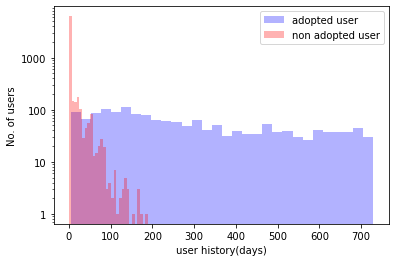

In [44]:
plot_hist_days(df2, 'history', 'user history(days)')
# history counts

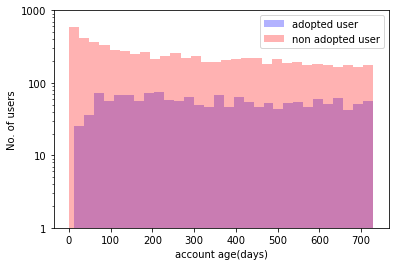

In [45]:
plot_hist_days(df2, 'account_age', 'account age(days)')
# adoption rate hasnt changed much over time but lower in newer accounts

In [57]:
model_data.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,history,account_age,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0.0,38,0,0,0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,136.0,196,1,1,0,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0.0,437,0,1,0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,1.0,374,0,0,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,5.0,498,0,0,0,0,0


In [54]:
y = model_data['adopted_user']
X = model_data.drop(['adopted_user', 'invited_by_user_id', 'history', 'name', 'email', 'creation_time'], axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [56]:
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
model_score = model.score(Xtest, ytest)
print('Random Forest Classifier')
print('Score: ', model_score)

TypeError: invalid type promotion

In [48]:
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

TypeError: invalid type promotion

In [107]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.